# Stimmungsanalyse für IMDB-Kommentare (Transformer)

In diesem Projekt führen wir eine Stimmungsanalyse der IMDB-Kommentare durch, um die allgemeine Stimmung der Kommentare zu ermitteln.

Zunächst laden wir die vorverarbeiteten Daten mit der Bibliothek "pandas". Die Daten werden in drei Sätze aufgeteilt: Training, Validierung und Test.

In [1]:
import pandas as pd
train = pd.read_csv('preprocessed/train.csv')
val = pd.read_csv('preprocessed/val.csv')
test = pd.read_csv('preprocessed/test.csv')

In [2]:
train

,review,sentiment
0,work librari expect like movi came 5 year ago ...,1
1,eagl wing pleasant surpris movi keep viewer in...,1
2,new york love collect work eleven short film s...,1
3,saw movi yesterday night one best made tv film...,1
4,playwright sidney bruhl wonder overthetop mich...,1
...,...,...
34702,love movi tv program record come nov 2nd reall...,1
34703,big jim carey fan took seat cinema optim fun d...,0
34704,even 6000 buck cast parttim actor christoph no...,1
34705,one best movi ive ever seen good act hank newm...,1


Wir benutzen das Model `DistilBERT` von der `transformers` Bibliothek für unsere Sentiment-Analyse. Wir benutzen außerdem den `DistilBERT` tokenizer um unsere Text Daten zu tokenisieren.

Im Code importieren wir zunächst die notwendigen Bibliotheken für die Arbeit mit PyTorch und die Bibliothek "Transformers". Dann laden wir den Tokenizer "DistilBERT", den wir zur Tokenisierung unserer Textdaten verwenden werden.

Als nächstes definieren wir eine benutzerdefinierte "SentimentDataset"-Klasse. Diese Klasse nimmt eine Liste von reviews und eine Liste von labels als Eingabe auf. Die Methode `__len__` gibt die Länge des Datensatzes zurück, während die Methode `__getitem__` ein Wörterbuch zurückgibt, das die tokenisierten Reviews, die Attention-Mask und das Label für einen bestimmten Index enthält.

In [3]:
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Convert your dataset into a PyTorch dataset
class SentimentDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews # store the list of reviews
        self.labels = labels # store the list of labels

    def __len__(self):
        return len(self.reviews) # return the length of the dataset

    def __getitem__(self, idx):
        review = self.reviews[idx] # get the review at the given index
        label = self.labels[idx] # get the label at the given index

        # Convert the review to inputs for the DistilBERT model
        input_ids = torch.tensor(tokenizer.encode(review, add_special_tokens=True)) # tokenize the review and get its input_ids
        max_length = 128 # set the maximum sequence length to 128
        padding_length = max_length - len(input_ids) # calculate the amount of padding needed
        input_ids = torch.nn.functional.pad(input_ids, (0, padding_length), value=0) # pad the input sequence with zeros
        attention_mask = torch.where(input_ids != 0, torch.tensor(1), torch.tensor(0)) # create an attention mask that distinguishes between padded and unpadded parts of the sequence

        return {
            "input_ids": input_ids.unsqueeze(0), # add a batch dimension to the input_ids tensor
            "attention_mask": attention_mask.unsqueeze(0), # add a batch dimension to the attention_mask tensor
            "labels": torch.tensor(label) # convert the label to a tensor and include it in the output dictionary
        }


Nachdem wir unsere benutzerdefinierte SentimentDataset-Klasse definiert haben, können wir sie verwenden, um PyTorch-Datensätze für unsere Trainings-, Validierungs- und Testdaten zu erstellen.

In [4]:
# create PyTorch datasets for training, validation, and testing
train_dataset = SentimentDataset(train["review"], train["sentiment"]) # create a dataset for training data using the SentimentDataset class
val_dataset = SentimentDataset(val["review"], val["sentiment"]) # create a dataset for validation data using the SentimentDataset class
test_dataset = SentimentDataset(test["review"], test["sentiment"]) # create a dataset for test data using the SentimentDataset class


Bevor wir unser Modell trainieren können, müssen wir einige Hyperparameter definieren und das vortrainierte Modell "DistilBERT" laden.

Wir setzen die Anzahl der Trainingsepochen auf 2 und laden das vortrainierte DistilBERT-Modell für die Sequenzklassifikation.

Als nächstes definieren wir die Loss-FunKtion, den Optimizer und den lr_scheduler, die wir während des Trainings verwenden werden. Wir verwenden binary cross-entropy loss als Verlustfunktion, da wir ein binäres Klassifikationsproblem lösen. Wir verwenden den Adam-Optimizer mit einer Lr von 2e-5, um die Lernrate im Laufe des Trainings schrittweise zu erhöhen und dann zu verringern.

In [5]:
epochs = 2
# Load the pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Define the loss function, optimizer, and learning rate scheduler
# binary cross-entropy loss for classification problem
loss_fn = torch.nn.BCEWithLogitsLoss() 
# Adam optimizer with a learning rate of 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5) 
 # one-cycle learning rate scheduler to gradually increase 
 # and then decrease the learning rate over the course of training
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                 max_lr=2e-5,
                                                 total_steps=len(train_dataset) * epochs, 
                                                 epochs=epochs)
# binary cross-entropy loss for binary classification problems 
criterion = torch.nn.BCELoss() 



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [6]:
# Define the train and validation data loaders
batch_size = 16 # number of samples in each batch
 # data loader for training data, shuffles data at each epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 # data loader for validation data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Jetzt können wir unser Model trainieren

ImCode durchlaufen wir jede Epoche in einer Schleife und trainieren unser Modell anhand der Trainingsdaten. Bei jeder Iteration der inneren Schleife holen wir einen Datenstapel aus dem train_loader, konvertieren die Daten in das richtige Format und konvertieren die Beschriftungen in eine One-Hot-Codierung. 

Nach  einer Epoche bewerten wir unser Modell anhand der Validierungsdaten.

In [ ]:
import numpy as np
import torch.nn.functional as F
import time

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))
    train_loss, val_loss = 0, 0
    train_acc, val_acc = 0, 0
    start_time = time.time()
    # Train the model
    model.train()
    for i, batch in enumerate(train_loader):
        # move data to proper dtype and device
        input_ids = batch["input_ids"].squeeze(1)
        attention_mask = batch["attention_mask"].squeeze(1)
        labels = batch["labels"]
        labels_one_hot = F.one_hot(labels, num_classes=2).float() # convert labels to one-hot encoding

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0] # get raw logits from model

        loss = loss_fn(logits, labels_one_hot) # compute loss using raw logits and one-hot encoded labels
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate the training loss
        train_loss += loss.item()

        # Calculate the accuracy
        pred = torch.argmax(logits, dim=1)
        train_acc += (pred == labels).sum().item()

        # Print progress information
        if (i+1) % 10 == 0:
            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time / (i+1) * (len(train_loader) - (i+1))
            current_acc = train_acc / ((i+1) * batch_size)
            print("Batch: {}/{} - Elapsed Time: {:.2f}s - Remaining Time: {:.2f}s - Train Acc: {:.4f}".format(i+1, len(train_loader), elapsed_time, remaining_time, current_acc))

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            input_ids = batch["input_ids"].squeeze(1)
            attention_mask = batch["attention_mask"].squeeze(1)
            labels = batch["labels"]
            labels_one_hot = F.one_hot(labels, num_classes=2).float() # convert labels to one-hot encoding

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs[0] # get raw logits from model

            loss = loss_fn(logits, labels_one_hot) # compute loss using raw logits and one-hot encoded labels

            val_loss += loss.item()

            # Calculate the accuracy
            pred = torch.argmax(logits, dim=1)
            val_acc += (pred == labels).sum().item()

    # Calculate the average losses and accuracies
    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    train_acc = train_acc / len(train_dataset)
    val_acc = val_acc / len(val_dataset)

    # Print the losses and accuracies
    print("Train Loss: {:.4f}, Val Loss: {:.4f}".format(train_loss, val_loss))
    print("Train Acc: {:.4f}, Val Acc: {:.4f}".format(train_acc, val_acc))

Epoch: 1/2
Batch: 10/2170 - Elapsed Time: 34.81s - Remaining Time: 7518.23s - Train Acc: 0.5125
Batch: 20/2170 - Elapsed Time: 62.48s - Remaining Time: 6716.38s - Train Acc: 0.5156
Batch: 30/2170 - Elapsed Time: 93.39s - Remaining Time: 6661.66s - Train Acc: 0.5437
Batch: 40/2170 - Elapsed Time: 127.03s - Remaining Time: 6764.51s - Train Acc: 0.5359
Batch: 50/2170 - Elapsed Time: 160.77s - Remaining Time: 6816.76s - Train Acc: 0.5238
Batch: 60/2170 - Elapsed Time: 193.24s - Remaining Time: 6795.64s - Train Acc: 0.5365
Batch: 70/2170 - Elapsed Time: 226.19s - Remaining Time: 6785.69s - Train Acc: 0.5321
Batch: 80/2170 - Elapsed Time: 256.90s - Remaining Time: 6711.56s - Train Acc: 0.5242
Batch: 90/2170 - Elapsed Time: 287.48s - Remaining Time: 6644.01s - Train Acc: 0.5194
Batch: 100/2170 - Elapsed Time: 318.21s - Remaining Time: 6586.98s - Train Acc: 0.5206
Batch: 110/2170 - Elapsed Time: 348.92s - Remaining Time: 6534.25s - Train Acc: 0.5210
Batch: 120/2170 - Elapsed Time: 379.65s - Re

Nachdem unser Modell trainiert wurde, können wir seine Leistung bewerten, indem wir die Trainingsgenauigkeit über die Zeit plotten. Dazu öffnen wir eine Textdatei mit Trainingsfortschrittsinformationen und extrahieren die relevanten Daten mit regulären Ausdrücken. Anschließend plotten wir die Trainingsgenauigkeit für die Batches, um zu visualisieren, wie sie sich im Laufe der Zeit verändert. Aufgrund von Ressourcenbeschränkungen konnten wir nur 2 Epochen trainieren und mussten daher den Plot pro 10 Batches erstellen, anstatt pro Epoche. Die 2 trainierten Epochen haben auf unserer Hardware schon mehrere Stunden in Anspruch genommen.

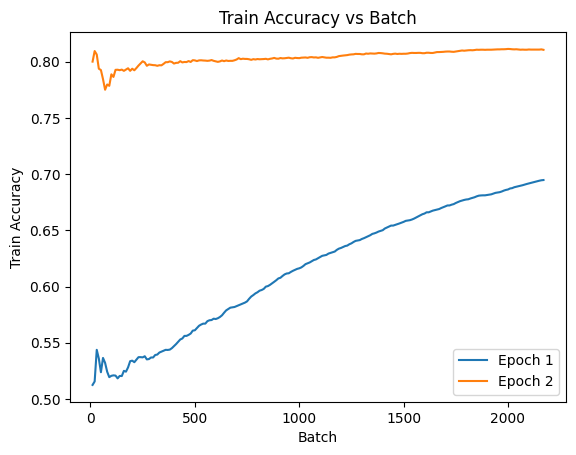

In [8]:

import re
import matplotlib.pyplot as plt

# Open and read the text file
with open('models/model_stats.txt', 'r') as f:
    contents = f.read()

# Initialize empty lists for data
epoch = []
batch = []
elapsed_time = []
remaining_time = []
train_acc = []

# Extract data from each line in the file
for line in contents.split('\n'):
    # Use regular expressions to extract data
    epoch_match = re.search('Epoch: (\d+)/\d+', line)
    batch_match = re.search('Batch: (\d+)/(\d+)', line)
    time_match = re.search('Elapsed Time: ([\d\.]+)s - Remaining Time: ([\d\.]+)s', line)
    acc_match = re.search('Train Acc: ([\d\.]+)', line)

    # Append extracted data to their respective lists
    if epoch_match:
        epoch.append(int(epoch_match.group(1)))
        # Append empty lists for each epoch to store batch and train accuracy data
        batch.append([])
        train_acc.append([])
    if batch_match:
        # Append batch and train accuracy data to the current epoch
        batch[-1].append(int(batch_match.group(1)))
    if acc_match:
        train_acc[-1].append(float(acc_match.group(1)))

# Plot the train accuracy for each epoch against batch
for i in range(len(epoch)):

    train_acc[i] = train_acc[i][:len(batch[i])]
    plt.plot(batch[i], train_acc[i], label='Epoch {}'.format(epoch[i]))

plt.xlabel('Batch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Batch')
plt.legend()
plt.show()

Es ist ersichtlich, dass die Genauigkeit über die Batches in der ersten und zweiten Epoche signifikant verbessert wird. Dabei ist zu beachten, dass frühere, niedrige Genauigkeiten immer in den aktuellen Batch-Genauigkeitswert einfließen. Eine Kurve stellt somit den kumulativen Genauigkeitswert dar. Dies erklärt auch den Sprung von der ersten zur zweiten Epoche, da die “alten Lasten” des weniger trainierten Modells mit dem Epochenwechsel sozusagen entfernt wurden. Man kann sehen, dass sich das Modell ständig verbessert. Aufgrund von Hardwarebeschränkungen konnten wir dieses tiefe neuronale Netzwerk jedoch nicht weiter trainieren und verwenden daher in den folgenden Notebooks einfachere, weniger parametrisierte Modelle.

Nach dem Training unseres Modells können wir seine Parameter in einer Datei speichern, so dass wir es später zur Bewertung oder zum weiteren Training laden können.

In [9]:
# Save the model as an h5 file
torch.save(model.state_dict(), 'models/DistilBERTSentimentAnalysis2Epochs.h5')

In [10]:
# Load the saved model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load('models/DistilBERTSentimentAnalysis2Epochs.h5'))

# Define the loss function, optimizer, and learning rate scheduler
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

Nachdem wir unser Modell trainiert haben, können wir seine Leistung anhand eines Testdatensatzes bewerten, um ein besseres Verständnis dafür zu bekommen, wie gut es auf neue Daten verallgemeinert werden kann. Dafür müssen wir die Testdaten auf die selbe Art behandeln wie die Train und Validation Daten. Die `test_model` Funktion übernimmt alle nötigen Schritte.

In [11]:
import torch.nn.functional as F
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            input_ids = data["input_ids"].squeeze(1)
            attention_mask = data["attention_mask"].squeeze(1)
            labels = data["labels"]
            labels_one_hot = F.one_hot(labels, num_classes=2).float() # Convert labels to one-hot encoding

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs[0] # Get raw logits from model

            loss = loss_fn(logits, labels_one_hot) # Compute loss using raw logits and one-hot encoded labels
            test_loss += loss.item()

            # Calculate the accuracy
            pred = torch.argmax(logits, dim=1)
            test_acc += (pred == labels).sum().item()

    # Calculate the average loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)

    # Print the test loss and accuracy
    print("Test Loss: {:.4f}, Test Acc: {:.4f}".format(test_loss, test_acc))


In [12]:
test_model(model=model,test_loader=test_loader)

Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


Test Loss: 0.0248, Test Acc: 0.8239


Nach 2 Epochen erreicht das Modell auf den Testdaten eine Genauigkeit von etwa 82,5%, was für die Anzahl der Epochen eine gute Leistung darstellt. Es ist wahrscheinlich, dass sich das Modell bei weiterem Training über mehr Epochen noch weiter verbessern würde.